In [57]:
from IPython.display import display
import IPython
import pandas as pd
from pandas import Series
import numpy as np
from random import randrange

from matplotlib import pyplot
import matplotlib.pyplot as plt
# from statsmodels.tsa.seasonal import seasonal_decompose

# np.float_ = np.float64
# from prophet import Prophet

import math
from typing import Any, List, Dict, AnyStr, Optional
from pathlib import Path
from glob import glob

from utils.dataset import MarketData, DataPreprocessor, Plotting
from utils.windowgenerator import WindowGenerator, compile_and_fit

import tensorflow as tf
import talib

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
test_df.to_csv('data/test_data.csv')

In [59]:
cot_df, auction_df, eua_df, ta_df, fundamentals_df = MarketData.latest(Path('data'))
cot_df = cot_df.set_index('Date').resample('W', origin='end').mean().reset_index()
auction_df = auction_df.set_index('Date').resample('D').mean().reset_index()


In [60]:
cot_df, auction_df, eua_df, ta_df, fundamentals_df = MarketData.latest(Path('data'))
cot_df = cot_df.set_index('Date').resample('W', origin='end').mean().reset_index()
auction_df = auction_df.set_index('Date').resample('D').mean().reset_index()


auction_df = auction_df[7:]
auction_df.loc[:, 'Premium/discount-settle'] = auction_df['Premium/discount-settle'].ffill()
auction_df.loc[:, ['Auc Price', 'Median Price', 'Cover Ratio', 'Spot Value',
'Auction Spot Diff', 'Median Spot Diff', 'Premium/discount-settle']] = auction_df[['Auc Price', 'Median Price', 'Cover Ratio', 'Spot Value', 
                                                                                          'Auction Spot Diff', 'Median Spot Diff', 'Premium/discount-settle']].ffill()

merged_df = DataPreprocessor.engineer_auction_features(auction_df)
# Define features and labels
FEATURES = merged_df.columns.tolist()
LABEL_COLS = ['Auc Price']

preprocessor = DataPreprocessor(features=FEATURES, label_columns=LABEL_COLS, input_width=7, label_width=7, shift=1)
train_df, test_df, val_df = preprocessor.train_test_data(merged_df)
train_df, test_df, val_df = preprocessor.normalize(train_df, test_df, val_df)
num_features = len(test_df.columns)

KeyboardInterrupt: 

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8115 - mean_absolute_error: 0.6716 - val_loss: 0.5429 - val_mean_absolute_error: 0.4484
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4839 - mean_absolute_error: 0.3827 - val_loss: 0.5019 - val_mean_absolute_error: 0.4129
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4537 - mean_absolute_error: 0.3577 - val_loss: 0.4512 - val_mean_absolute_error: 0.3797
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4026 - mean_absolute_error: 0.3330 - val_loss: 0.4055 - val_mean_absolute_error: 0.3435
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3635 - mean_absolute_error: 0.3077 - val_loss: 0.3792 - val_mean_absolute_error: 0.3220
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3431 - mean_absolute_error: 0.2939 - val_loss: 0.3658 - val_mean_absolute_error: 0.3122
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3266 - mean_absolute_error: 0.2841 - val_loss: 0.356

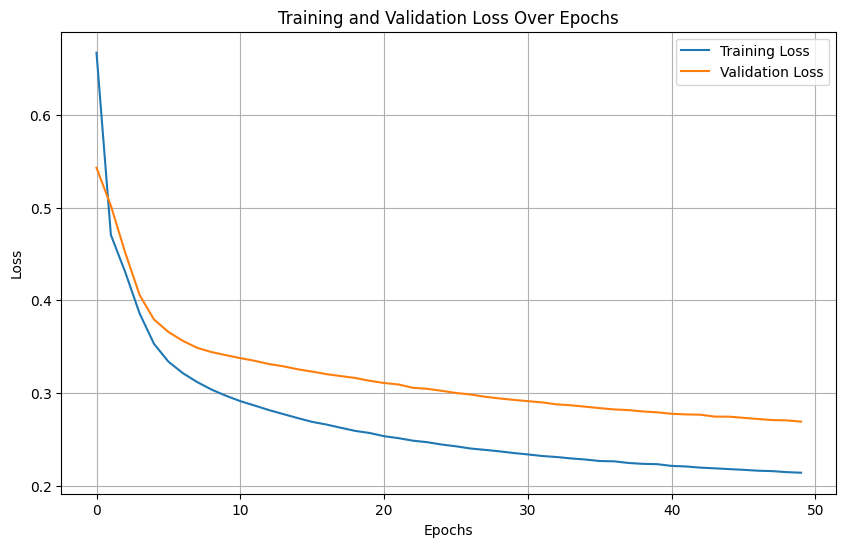

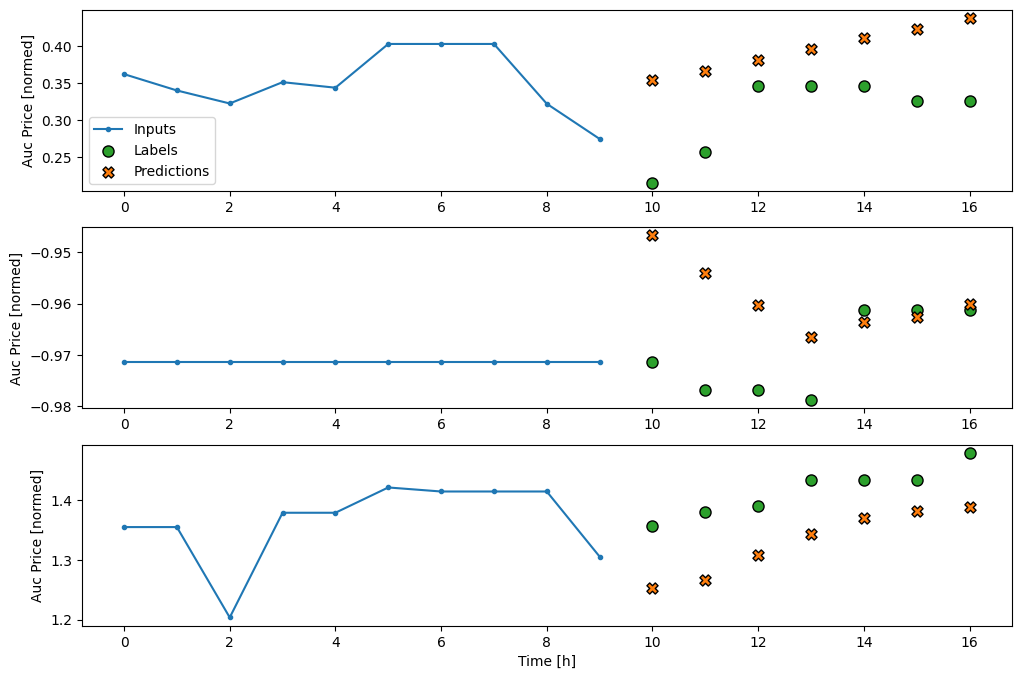

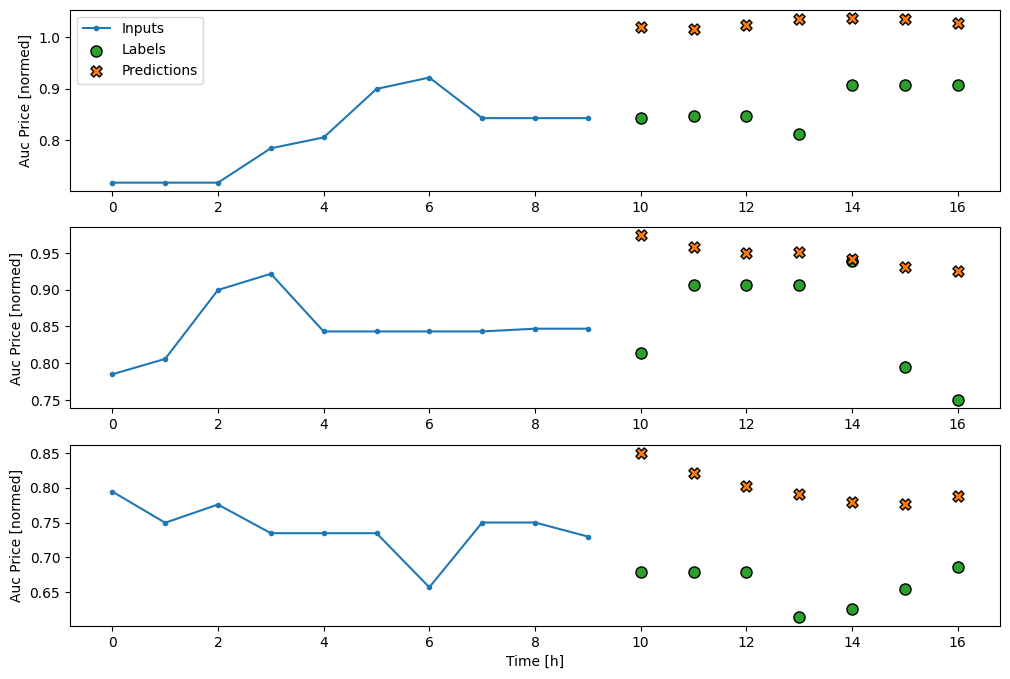

In [8]:
OUT_STEPS = 7
INPUT_WIDTH = 10
multi_window = WindowGenerator(input_width=INPUT_WIDTH,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

def compile_and_fit(self, model: tf.keras.Model, 
                    window: WindowGenerator, 
                    patience: int = 2, 
                    max_epochs: int = 20,
                    use_early_stopping: bool = True):
        callbacks = []
        if use_early_stopping:
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
            callbacks.append(early_stopping)
        
        model.compile(loss=tf.keras.losses.MeanSquaredError(), 
                    optimizer=tf.keras.optimizers.Adam(), 
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])
        
        history = model.fit(window.train, epochs=max_epochs, validation_data=window.val, callbacks=callbacks)
        return history

multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
history = preprocessor.compile_and_fit(multi_lstm_model, multi_window, use_early_stopping=False, max_epochs=50)

Plotting.plot_history(history)
multi_window.plot(multi_lstm_model)
multi_window.plot_test(multi_lstm_model)

In [41]:
import os

MODEL_DIR = Path('../models')

In [9]:
def sequential_predict_and_plot(model, test_df, input_width, out_steps, features):
    num_features = len(features)
    predictions = []
    inputs = test_df.iloc[:input_width].values

    for i in range(input_width, len(test_df) - out_steps + 1, out_steps):
        inputs = inputs[-input_width:]
        if inputs.shape[0] != input_width or inputs.shape[1] != num_features:
            raise ValueError(f"Expected input shape ({input_width}, {num_features}), but got {inputs.shape}")
        inputs_reshaped = inputs.reshape((1, input_width, num_features))
        preds = model.predict(inputs_reshaped)
        predictions.append(preds[0])
        # inputs = np.concatenate([inputs, preds[0]])
        inputs = np.concatenate([inputs, test_df.iloc[i:i+out_steps].values])

    predictions = np.concatenate(predictions, axis=0)
    predictions_df = pd.DataFrame(predictions, columns=features, index=test_df.index[input_width:input_width + len(predictions)])

    plt.figure(figsize=(12, 6))
    plt.plot(test_df.index, test_df['Auc Price'], label='Actual Auc Price')
    plt.plot(predictions_df.index, predictions_df['Auc Price'], label='Predicted Auc Price', linestyle='dashed')
    plt.xlabel('Date')
    plt.ylabel('Auc Price')
    plt.title('Actual vs Predicted Auc Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [49]:
multi_lstm_model.save('models/multi_lstm_model.keras')

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_model_results(model, test_df, input_width, out_steps):
    features = test_df.columns
    num_features = len(features)
    predictions = []
    inputs = test_df.iloc[:input_width].values

    def check_gradient(values):
        gradient = np.gradient(values)
        return 'positive' if np.all(gradient > 0) else 'negative'

    for idx, i in enumerate(range(input_width, len(test_df) - out_steps + 1, out_steps)):
        try:    
            inputs = test_df[i-input_width:i].values
            inputs_reshaped = inputs.reshape((1, input_width, num_features))

            preds = model.predict(inputs_reshaped)
            predictions.append(preds[0])
            inputs = np.concatenate([inputs, test_df[i:i+out_steps].values])
        except Exception as e:
            break

    predictions = np.concatenate(predictions, axis=0)
    predictions_df = pd.DataFrame(predictions, columns=features, index=test_df.index[input_width:input_width + len(predictions)])

    plt.figure(figsize=(12, 5))
    plt.plot(test_df.index, test_df['Auc Price'], label='Actual Auc Price')

    for idx, i in enumerate(range(input_width, len(test_df) - out_steps + 1, out_steps)):
        trend = check_gradient(predictions_df['Auc Price'][idx* out_steps:(idx+1)* out_steps].values)
        single_point_index = predictions_df.index[idx* out_steps:(idx+1)* out_steps][0]
        single_point_value = test_df[test_df.index == single_point_index]['Auc Price'].values[0]
        prev_timestamp = single_point_index - pd.to_timedelta(1, unit='d')
        prev_auc_price = test_df[test_df.index == prev_timestamp]['Auc Price'].values[0]
        pred_diff = np.mean(predictions_df['Auc Price'][idx* out_steps:(idx+1)* out_steps].values) - prev_auc_price

        if pred_diff > 0:
            plt.scatter(single_point_index, single_point_value, color='green', marker='o')
            plt.text(single_point_index, single_point_value, "Buy", fontsize=8, verticalalignment='top')
            plt.plot(predictions_df.index[idx* out_steps:(idx+1)* out_steps], 
                 predictions_df['Auc Price'][idx* out_steps:(idx+1)* out_steps], 
                 label=f'Predicted Auc Price {idx+1}', linestyle='dashed', color='green')
        else: 
            plt.scatter(single_point_index, single_point_value, color='red', marker='o')
            plt.text(single_point_index, single_point_value, "Sell", fontsize=8, verticalalignment='top')
            plt.plot(predictions_df.index[idx* out_steps:(idx+1)* out_steps], 
                 predictions_df['Auc Price'][idx* out_steps:(idx+1)* out_steps], 
                 label=f'Predicted Auc Price {idx+1}', linestyle='dashed', color='red')

    plt.xlabel('Date')
    plt.ylabel('Auc Price')
    plt.title('Actual vs Predicted Auc Price')
    plt.grid(True)
    plt.show()


# •Predictions Generation: The script uses the model to generate predictions on the test data in steps of out_steps. It reshapes the inputs accordingly and collects the predictions.
# •Signal Determination: For each prediction window, it calculates the mean predicted price and compares it to the previous day’s actual price to decide whether to ‘Buy’ or ‘Sell’.
# •Trade Simulation: It simulates the trade over the next out_steps days, checking each day if the take profit or stop loss levels are hit. If neither is hit, it closes the trade at the last available price in the window.
# •Profit/Loss Calculation: The profit or loss for each trade is calculated based on the entry and exit prices and the position size.
# •Balance Update: The script updates the account balance after each trade and logs the trade details.
# •Outputs: At the end, it returns a DataFrame containing the trade log, the total return from backtesting, and the balance history.
def backtest_model(model, test_df, input_width, out_steps, initial_balance, take_profit, stop_loss):
    """
    Backtesting function for the given model and test data.

    Parameters:
    - model: The trained prediction model.
    - test_df: DataFrame containing test data with 'Auc Price' column.
    - input_width: The number of past days used for making predictions.
    - out_steps: The number of future days the model predicts.
    - initial_balance: Initial amount of money in the account.
    - take_profit: Profit percentage at which to close the trade.
    - stop_loss: Loss percentage at which to close the trade.

    Returns:
    - trade_log_df: DataFrame containing the log of trades executed.
    - total_return: Total return from the backtesting.
    - balance_history: List containing the balance after each trade.
    """
    features = test_df.columns
    num_features = len(features)
    predictions = []

    # Initialize balance and trade log
    balance = initial_balance
    balance_history = [balance]
    trade_log = []
    position_size = initial_balance  # Using full balance per trade for simplicity

    # Generate predictions in steps of 'out_steps'
    for idx, i in enumerate(range(input_width, len(test_df) - out_steps + 1, out_steps)):
        try:
            inputs = test_df[i - input_width:i].values
            inputs_reshaped = inputs.reshape((1, input_width, num_features))
            preds = model.predict(inputs_reshaped)
            predictions.append(preds[0])
        except Exception as e:
            print(f"Prediction error at index {i}: {e}")
            break

    # Create DataFrame for predictions
    predictions = np.concatenate(predictions, axis=0)
    pred_indices = test_df.index[input_width:input_width + len(predictions)]
    predictions_df = pd.DataFrame(predictions, columns=features, index=pred_indices)

    # Simulate trades based on predictions
    for idx, i in enumerate(range(input_width, len(test_df) - out_steps + 1, out_steps)):
        entry_index = predictions_df.index[idx * out_steps]
        entry_price = test_df.loc[entry_index, 'Auc Price']
        prev_index = entry_index - pd.Timedelta(days=1)
        prev_price = test_df.loc[prev_index, 'Auc Price'] if prev_index in test_df.index else entry_price

        # Determine signal based on predicted mean price
        pred_mean = predictions_df['Auc Price'][idx * out_steps:(idx + 1) * out_steps].mean()
        signal = 'Buy' if pred_mean > prev_price else 'Sell'

        trade_closed = False
        exit_price = None
        exit_date = None

        # Simulate trade over the next 'out_steps' days
        for offset in range(1, out_steps + 1):
            current_index = entry_index + pd.Timedelta(days=offset)
            if current_index not in test_df.index:
                continue
            current_price = test_df.loc[current_index, 'Auc Price']

            # Calculate return percentage
            if signal == 'Buy':
                return_pct = (current_price - entry_price) / entry_price
                if return_pct >= take_profit:
                    exit_price = entry_price * (1 + take_profit)
                    exit_date = current_index
                    trade_closed = True
                    break
                elif return_pct <= -stop_loss:
                    exit_price = entry_price * (1 - stop_loss)
                    exit_date = current_index
                    trade_closed = True
                    break
            else:  # Sell signal
                return_pct = (entry_price - current_price) / entry_price
                if return_pct >= take_profit:
                    exit_price = entry_price * (1 - take_profit)
                    exit_date = current_index
                    trade_closed = True
                    break
                elif return_pct <= -stop_loss:
                    exit_price = entry_price * (1 + stop_loss)
                    exit_date = current_index
                    trade_closed = True
                    break

        # If trade not closed, close at the last available price
        if not trade_closed:
            last_index = entry_index + pd.Timedelta(days=out_steps)
            while last_index not in test_df.index and last_index > entry_index:
                last_index -= pd.Timedelta(days=1)
            if last_index in test_df.index:
                exit_price = test_df.loc[last_index, 'Auc Price']
                exit_date = last_index
            else:
                # If exit price not found, skip the trade
                print(f"Exit price not found for trade starting on {entry_index}")
                continue

        # Calculate profit or loss
        if signal == 'Buy':
            profit_loss = (exit_price - entry_price) / entry_price * position_size
        else:  # Sell
            profit_loss = (entry_price - exit_price) / entry_price * position_size

        # Update balance and log the trade
        balance += profit_loss
        balance_history.append(balance)
        trade_log.append({
            'Entry Date': entry_index,
            'Exit Date': exit_date,
            'Signal': signal,
            'Entry Price': entry_price,
            'Exit Price': exit_price,
            'Profit/Loss': profit_loss,
            'Balance': balance
        })

    # Convert trade log to DataFrame
    trade_log_df = pd.DataFrame(trade_log)

    # Calculate total return
    total_return = (balance - initial_balance) / initial_balance

    return trade_log_df, total_return, balance_history

def backtest_model_with_metrics(
    model, test_df, input_width, out_steps,
    initial_balance, take_profit, stop_loss,
    position_size_fraction=0.1,  # 10% of current balance per trade
    risk_free_rate=0.01  # Annual risk-free rate for Sharpe ratio
):
    """
    Backtesting function for the given model and test data with position sizing and performance metrics.

    Parameters:
    - model: The trained prediction model.
    - test_df: DataFrame containing test data with 'Auc Price' column.
    - input_width: The number of past days used for making predictions.
    - out_steps: The number of future days the model predicts.
    - initial_balance: Initial amount of money in the account.
    - take_profit: Profit percentage at which to close the trade.
    - stop_loss: Loss percentage at which to close the trade.
    - position_size_fraction: Fraction of current balance to use per trade.
    - risk_free_rate: Risk-free rate for performance metrics calculations.

    Returns:
    - trade_log_df: DataFrame containing the log of trades executed.
    - performance_metrics: Dictionary containing various performance metrics.
    - balance_history: DataFrame containing balance history over time.
    """
    features = test_df.columns
    num_features = len(features)
    predictions = []

    # Initialize balance and trade log
    balance = initial_balance
    balance_history = []
    trade_log = []

    # For performance metrics
    returns = []
    equity_curve = [initial_balance]

    # Generate predictions in steps of 'out_steps'
    for idx, i in enumerate(range(input_width, len(test_df) - out_steps + 1, out_steps)):
        try:
            inputs = test_df[i - input_width:i].values
            inputs_reshaped = inputs.reshape((1, input_width, num_features))
            preds = model.predict(inputs_reshaped)
            predictions.append(preds[0])
        except Exception as e:
            print(f"Prediction error at index {i}: {e}")
            break

    # Create DataFrame for predictions
    predictions = np.concatenate(predictions, axis=0)
    pred_indices = test_df.index[input_width:input_width + len(predictions)]
    predictions_df = pd.DataFrame(predictions, columns=features, index=pred_indices)

    # Simulate trades based on predictions
    for idx, i in enumerate(range(input_width, len(test_df) - out_steps + 1, out_steps)):
        entry_index = predictions_df.index[idx * out_steps]
        entry_price = test_df.loc[entry_index, 'Auc Price']
        prev_index = entry_index - pd.Timedelta(days=1)
        prev_price = test_df.loc[prev_index, 'Auc Price'] if prev_index in test_df.index else entry_price

        # Determine signal based on predicted mean price
        pred_mean = predictions_df['Auc Price'][idx * out_steps:(idx + 1) * out_steps].mean()
        signal = 'Buy' if pred_mean > prev_price else 'Sell'

        trade_closed = False
        exit_price = None
        exit_date = None

        # Position sizing
        position_size = balance * position_size_fraction

        # Simulate trade over the next 'out_steps' days
        for offset in range(1, out_steps + 1):
            current_index = entry_index + pd.Timedelta(days=offset)
            if current_index not in test_df.index:
                continue
            current_price = test_df.loc[current_index, 'Auc Price']

            # Calculate return percentage
            if signal == 'Buy':
                return_pct = (current_price - entry_price) / entry_price
                if return_pct >= take_profit:
                    exit_price = entry_price * (1 + take_profit)
                    exit_date = current_index
                    trade_closed = True
                    break
                elif return_pct <= -stop_loss:
                    exit_price = entry_price * (1 - stop_loss)
                    exit_date = current_index
                    trade_closed = True
                    break
            else:  # Sell signal
                return_pct = (entry_price - current_price) / entry_price
                if return_pct >= take_profit:
                    exit_price = entry_price * (1 - take_profit)
                    exit_date = current_index
                    trade_closed = True
                    break
                elif return_pct <= -stop_loss:
                    exit_price = entry_price * (1 + stop_loss)
                    exit_date = current_index
                    trade_closed = True
                    break

        # If trade not closed, close at the last available price
        if not trade_closed:
            last_index = entry_index + pd.Timedelta(days=out_steps)
            while last_index not in test_df.index and last_index > entry_index:
                last_index -= pd.Timedelta(days=1)
            if last_index in test_df.index:
                exit_price = test_df.loc[last_index, 'Auc Price']
                exit_date = last_index
            else:
                # If exit price not found, skip the trade
                print(f"Exit price not found for trade starting on {entry_index}")
                continue

        # Calculate profit or loss
        if signal == 'Buy':
            profit_loss = (exit_price - entry_price) / entry_price * position_size
        else:  # Sell
            profit_loss = (entry_price - exit_price) / entry_price * position_size

        # Update balance and log the trade
        balance += profit_loss
        returns.append(profit_loss / position_size)  # Return percentage for this trade
        equity_curve.append(balance)
        balance_history.append({'Date': exit_date, 'Balance': balance})

        trade_log.append({
            'Entry Date': entry_index,
            'Exit Date': exit_date,
            'Signal': signal,
            'Entry Price': entry_price,
            'Exit Price': exit_price,
            'Profit/Loss': profit_loss,
            'Return (%)': (profit_loss / position_size) * 100,
            'Balance': balance
        })

    # Convert trade log and balance history to DataFrames
    trade_log_df = pd.DataFrame(trade_log)
    balance_history_df = pd.DataFrame(balance_history).set_index('Date')

    # Calculate performance metrics
    total_return = (balance - initial_balance) / initial_balance
    num_years = (test_df.index[-1] - test_df.index[input_width]).days / 365.25
    CAGR = (balance / initial_balance) ** (1 / num_years) - 1 if num_years > 0 else 0

    # Maximum Drawdown
    equity_series = pd.Series(equity_curve)
    cumulative_returns = equity_series / equity_series.cummax() - 1
    max_drawdown = cumulative_returns.min()

    # Sharpe Ratio
    excess_returns = np.array(returns) - (risk_free_rate / 252)
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252) if np.std(excess_returns) != 0 else np.nan

    # Sortino Ratio
    negative_returns = excess_returns[excess_returns < 0]
    downside_std = np.std(negative_returns)
    sortino_ratio = np.mean(excess_returns) / downside_std * np.sqrt(252) if downside_std != 0 else np.nan

    # Win Rate
    num_trades = len(trade_log_df)
    num_wins = len(trade_log_df[trade_log_df['Profit/Loss'] > 0])
    win_rate = num_wins / num_trades if num_trades > 0 else np.nan

    # Average Profit per Trade
    avg_profit = trade_log_df['Profit/Loss'].mean()

    # Profit Factor
    gross_profit = trade_log_df[trade_log_df['Profit/Loss'] > 0]['Profit/Loss'].sum()
    gross_loss = -trade_log_df[trade_log_df['Profit/Loss'] < 0]['Profit/Loss'].sum()
    profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.nan

    performance_metrics = {
        'Total Return (%)': total_return * 100,
        'CAGR (%)': CAGR * 100,
        'Maximum Drawdown (%)': max_drawdown * 100,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Win Rate (%)': win_rate * 100,
        'Average Profit per Trade': avg_profit,
        'Profit Factor': profit_factor
    }

    return trade_log_df, performance_metrics, balance_history_df

In [19]:
# Assuming you have your model, test_df, input_width, and out_steps defined
initial_balance = 10000  # Starting with $10,000
take_profit = 0.05       # 5% take profit
stop_loss = 0.01         # 2% stop loss

trade_log_df, total_return, balance_history = backtest_model(
    multi_lstm_model,
    test_df,
    INPUT_WIDTH,
    OUT_STEPS,
    initial_balance,
    take_profit,
    stop_loss
)

print(trade_log_df)
print(f"Total Return: {total_return * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
   Entry Date  Exit Date Signal  Entry Price  Exit Price  Profit/Loss  Balance
0  2024-04-11 2024-04-12   Sell     0.492742    0.497669       -100.0   9900.0
1  2024-04-18 2024-04-19   Sell     0.632016    0.638336       -100.0   9800.0
2  2024-04-25 2024-04-29    Buy     0.554724    0.549177       -100.0   9700.0
3  2024-05-02 2024-05-03    Buy     0.667488    0.700862        500.0  10200.0
4  2024-05-09 2024-05-14   Sell     0.700719    

In [34]:
# Assuming you have your model, test_df, input_width, and out_steps defined
initial_balance = 10000  # Starting with $10,000
take_profit = 0.05       # 5% take profit
stop_loss = 0.02         # 2% stop loss
position_size_fraction = 1  # Use 10% of current balance per trade

trade_log_df, performance_metrics, balance_history_df = backtest_model_with_metrics(
    multi_lstm_model,
    test_df,
    10,
    7,
    initial_balance,
    take_profit,
    stop_loss,
    position_size_fraction=position_size_fraction
)

print(trade_log_df)
print("\nPerformance Metrics:")
for metric, value in performance_metrics.items():
    print(f"{metric}: {value:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
   Entry Date  Exit Date Signal  Entry Price  Exit Price  Profit/Loss  \
0  2024-04-11 2024-04-12   Sell     0.492742    0.502597  -200.000000   
1  2024-04-18 2024-04-19   Sell     0.632016    0.644656  -196.000000   
2  2024-04-25 2024-04-29    Buy     0.554724    0.543630  -192.080000   
3  2024-05-02 2024-05-03    Buy     0.667488    0.700862   470.596000   
4  2024-05-09 2024-05-14   Sell     0.700719    0.665683   494.125800   
5  202

In [56]:
balance_history_df.reset_index()

Date              datetime64[ns]
Balance                  float64
Cumulative Max           float64
Drawdown                 float64
dtype: object

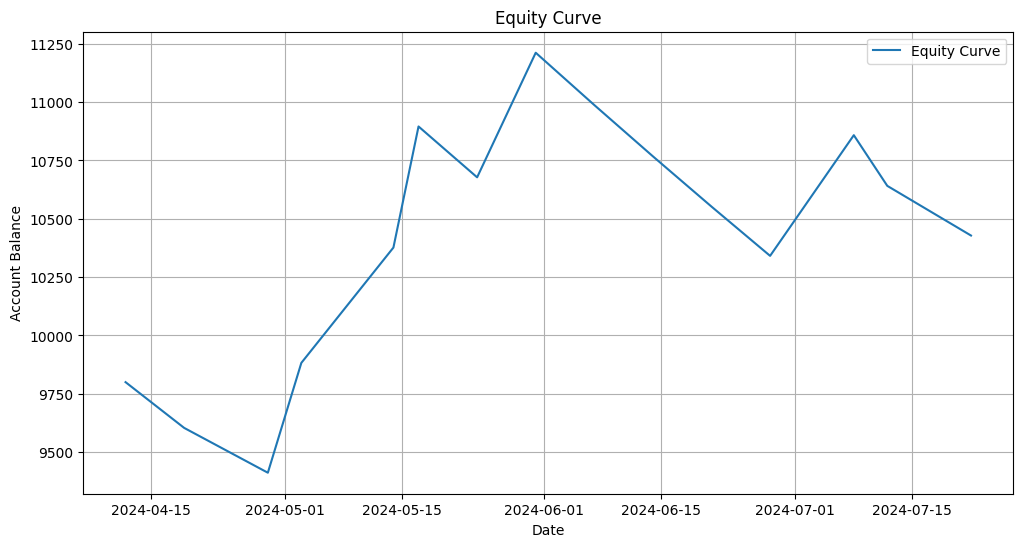

In [36]:
import matplotlib.pyplot as plt

# Plot Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(balance_history_df.index, balance_history_df['Balance'], label='Equity Curve')
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Account Balance')
plt.legend()
plt.grid(True)
plt.show()

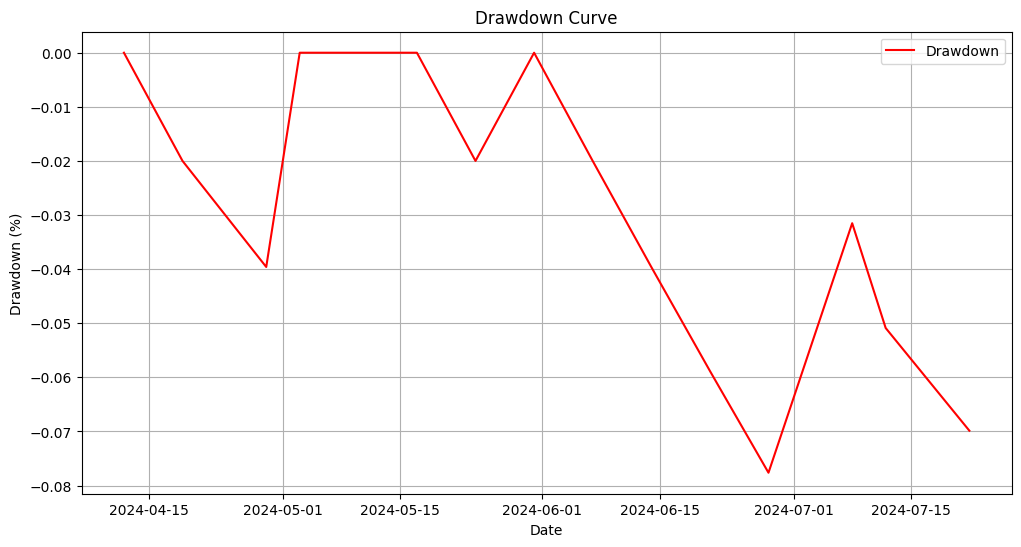

In [37]:
# Calculate Drawdown
balance_history_df['Cumulative Max'] = balance_history_df['Balance'].cummax()
balance_history_df['Drawdown'] = balance_history_df['Balance'] / balance_history_df['Cumulative Max'] - 1

# Plot Drawdown
plt.figure(figsize=(12, 6))
plt.plot(balance_history_df.index, balance_history_df['Drawdown'], label='Drawdown', color='red')
plt.title('Drawdown Curve')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


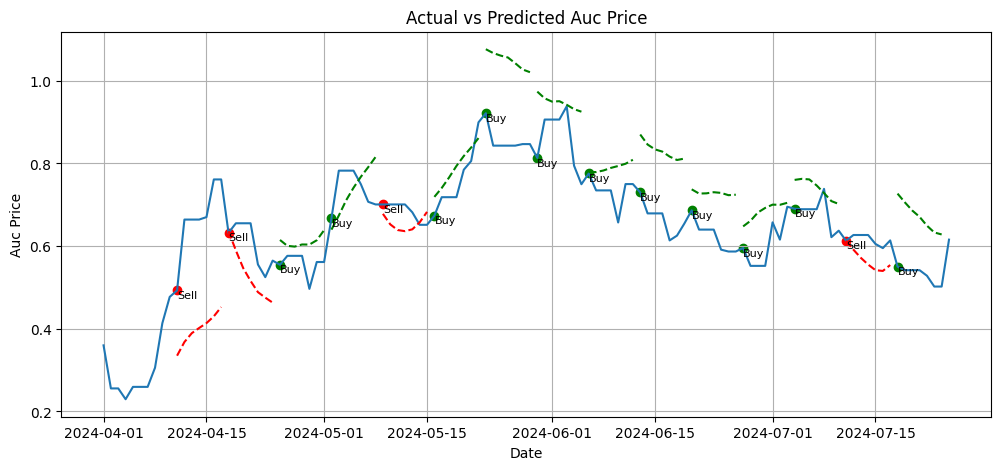

In [13]:
plot_model_results(multi_lstm_model, test_df, INPUT_WIDTH, OUT_STEPS)


Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5751 - mean_absolute_error: 0.4896 - val_loss: 0.3448 - val_mean_absolute_error: 0.2971
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3057 - mean_absolute_error: 0.2667 - val_loss: 0.3200 - val_mean_absolute_error: 0.2704
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2749 - mean_absolute_error: 0.2470 - val_loss: 0.3054 - val_mean_absolute_error: 0.2619
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2676 - mean_absolute_error: 0.2414 - val_loss: 0.2945 - val_mean_absolute_error: 0.2570
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2536 - mean_absolute_error: 0.2345 - val_loss: 0.2904 - val_mean_absolute_error: 0.2574
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2488 - mean_absolute_error: 0.2336 - val_loss: 0.2854 - val_mean_absolute_error: 0.2560
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2404 - mean_absolute_error: 0.2290 - val_loss: 0.278

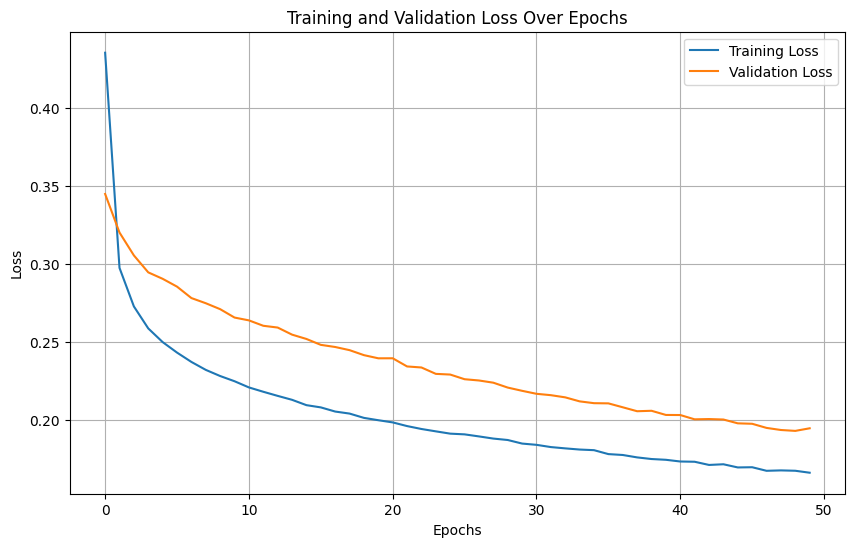

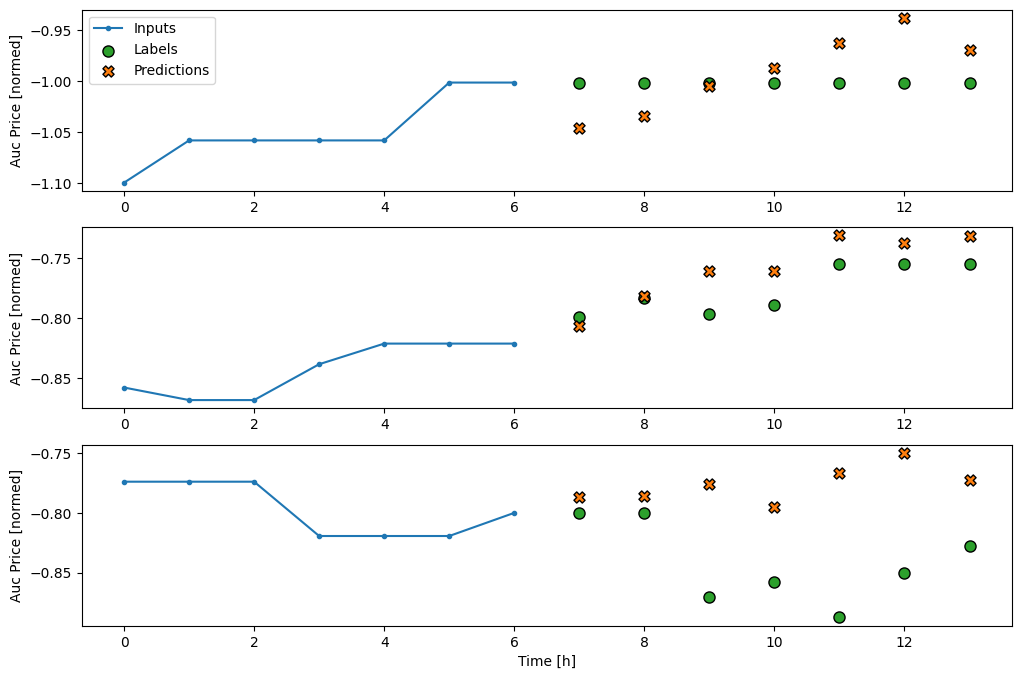

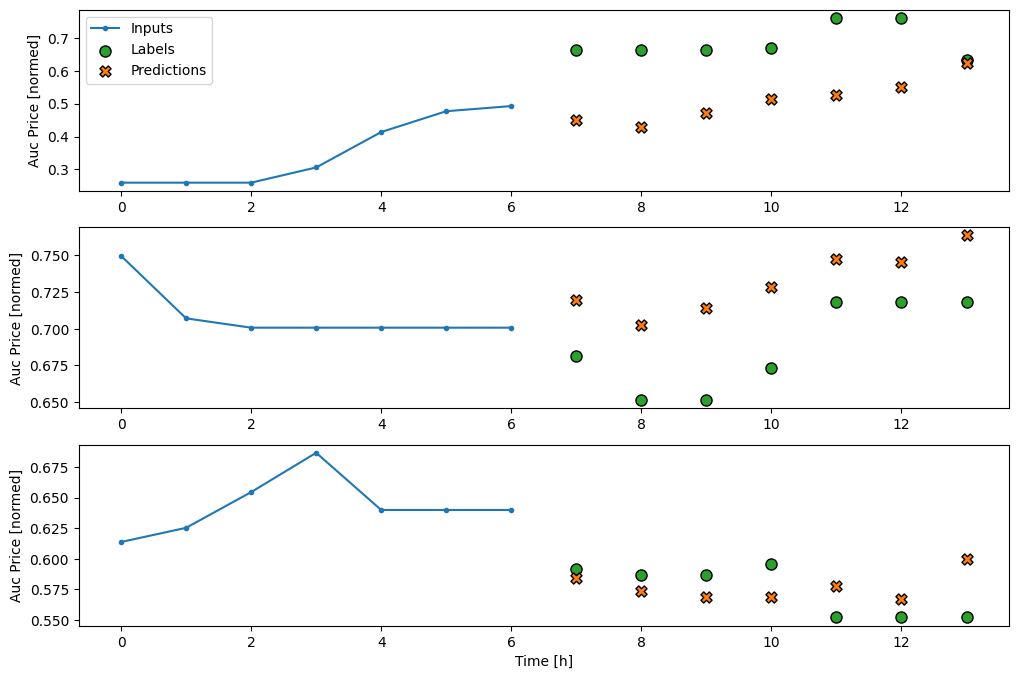

In [20]:
OUT_STEPS = 7
INPUT_STEPS = 7
multi_window = WindowGenerator(input_width=7,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = preprocessor.compile_and_fit(multi_conv_model, multi_window, use_early_stopping=True, max_epochs=50)
# multi_val_performance['Multi Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
# multi_performance['Multi Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=1, return_dict=True)
Plotting.plot_history(history)
multi_window.plot(multi_conv_model)
multi_window.plot_test(multi_conv_model)

In [50]:
multi_conv_model.save('models/multi_conv_model.keras')

In [30]:
# Assuming you have your model, test_df, input_width, and out_steps defined
initial_balance = 10000  # Starting with $10,000
take_profit = 0.05       # 5% take profit
stop_loss = 0.01         # 2% stop loss

trade_log_df, total_return, balance_history = backtest_model(
    multi_conv_model,
    test_df,
    INPUT_WIDTH,
    OUT_STEPS,
    initial_balance,
    take_profit,
    stop_loss
)

print(trade_log_df)
print(f"Total Return: {total_return * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
   Entry Date  Exit Date Signal  Entry Price  Exit Price  Profit/Loss  Balance
0  2024-04-11 2024-04-12    Buy     0.492742    0.517379        500.0  10500.0
1  2024-04-18 2024-04-19   Sell     0.632016    0.638336       -100.0  10400.0
2  2024-04-25 2024-04-29    Buy     0.554724    0.549177       -100.0  10300.0
3  2024-05-02 2024-05-03    Buy     0.667488    0.700862        500.0  10800.0
4  2024-05-09 2024-05-13    Buy     0.700719    0.

In [31]:
total_return

0.3300000000000009

In [32]:
# Assuming you have your model, test_df, input_width, and out_steps defined
initial_balance = 10000  # Starting with $10,000
take_profit = 0.05       # 5% take profit
stop_loss = 0.02         # 2% stop loss
position_size_fraction = 1  # Use 10% of current balance per trade

trade_log_df, performance_metrics, balance_history_df = backtest_model_with_metrics(
    multi_conv_model,
    test_df,
    7,
    7,
    initial_balance,
    take_profit,
    stop_loss,
    position_size_fraction=position_size_fraction
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [68]:
pd.DataFrame(performance_metrics.items(), columns=["Metric", "Value"])

,Metric,Value
0,Total Return (%),4.281496e+00
1,CAGR (%),1.570050e+01
2,Maximum Drawdown (%),-7.763184e+00
3,Sharpe Ratio,1.584477e+00
4,Sortino Ratio,1.121395e+15
5,Win Rate (%),3.333333e+01
6,Average Profit per Trade,2.854331e+01
7,Profit Factor,1.203267e+00


In [33]:
performance_metrics

{'Total Return (%)': 37.423228034391016,
 'CAGR (%)': 193.02976920664028,
 'Maximum Drawdown (%)': -3.959999999999997,
 'Sharpe Ratio': 10.165651651074002,
 'Sortino Ratio': 8010659295277251.0,
 'Win Rate (%)': 60.0,
 'Average Profit per Trade': 249.48818689594017,
 'Profit Factor': 3.585836738832591}

In [28]:
trade_log_df

,Entry Date,Exit Date,Signal,Entry Price,Exit Price,Profit/Loss,Return (%),Balance
0,2024-04-08,2024-04-09,Buy,0.305675,0.320958,50.000000,5.0,10050.000000
1,2024-04-15,2024-04-16,Sell,0.670101,0.683503,-20.100000,-2.0,10029.900000
2,2024-04-22,2024-04-23,Sell,0.555471,0.527698,50.149500,5.0,10080.049500
3,2024-04-29,2024-04-30,Buy,0.496476,0.521300,50.400248,5.0,10130.449747
4,2024-05-06,2024-05-07,Sell,0.749633,0.712151,50.652249,5.0,10181.101996
5,2024-05-13,2024-05-14,Buy,0.681676,0.668043,-20.362204,-2.0,10160.739792
6,2024-05-20,2024-05-22,Buy,0.784731,0.823968,50.803699,5.0,10211.543491
7,2024-05-27,2024-05-31,Sell,0.842980,0.859840,-20.423087,-2.0,10191.120404
8,2024-06-03,2024-06-04,Sell,0.938194,0.891284,50.955602,5.0,10242.076006
9,2024-06-10,2024-06-11,Sell,0.657033,0.670173,-20.484152,-2.0,10221.591854


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


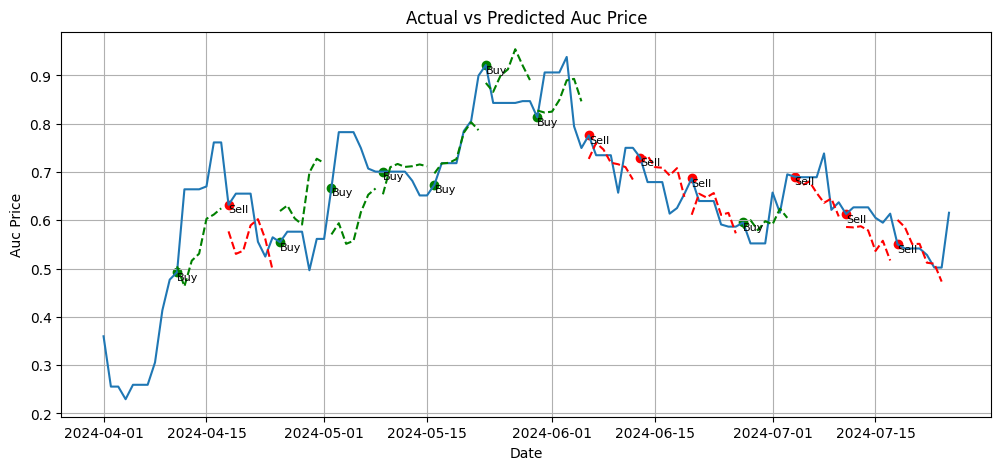

In [16]:
plot_model_results(multi_conv_model, test_df, INPUT_WIDTH, OUT_STEPS)
